# <center> **Практика:**
## <center> **Линейная Алгебра в Контексте Линейных Методов**

### <center> Прогнозирование Выработки Газа на Скважинах

### **Постановка Задачи**

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
#import libraries
import pandas as pd, numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#scaling
from sklearn import preprocessing

#machine learning
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model

#hyperparameters
import optuna
from optuna import Trial, study, samplers

#outliers analysis
from sklearn.ensemble import IsolationForest

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


### **Практика**:
### **Линейная Регрессия по Методу Наименьших Квадратов**

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

#### **Задание 5.0**

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [3]:
#basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [4]:
#basic statistical analysis
data.describe().round()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
count,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
mean,100.0,15.0,4.0,3.0,48.0,1.0,2.0,4311.0
std,58.0,3.0,2.0,1.0,14.0,0.0,0.0,992.0
min,1.0,7.0,1.0,1.0,11.0,-0.0,1.0,2107.0
25%,51.0,13.0,3.0,3.0,38.0,1.0,2.0,3618.0
50%,100.0,15.0,4.0,3.0,50.0,1.0,2.0,4285.0
75%,150.0,17.0,5.0,3.0,58.0,1.0,2.0,5086.0
max,200.0,24.0,10.0,5.0,84.0,2.0,3.0,6663.0


##### **Null Values**

In [5]:
#check for null values
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

##### **Duplicates**

In [6]:
#check for duplicates
dupl_columns = list(data.columns)

mask = data.duplicated(subset=dupl_columns)
unconv_duplicates = data[mask]
print(f'Number of Duplicates: {unconv_duplicates.shape[0]}')

Number of Duplicates: 0


##### **Outliers**

In [7]:
#find the features
data.columns

Index(['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod'], dtype='object')

In [8]:
#input the features into a specific list
anomaly_inputs_mx = ['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

In [9]:
#create an object class to look for outliers
model_IF_mx = IsolationForest(contamination=0.1,
                              random_state=42)

#model learning through IsolationForest
model_IF_mx.fit(data[anomaly_inputs_mx])

IsolationForest(contamination=0.1, random_state=42)

In [10]:
#create a feature to show the likelihood % of a variable being an anomaly
data['anomaly_scores'] = model_IF_mx.decision_function(data[anomaly_inputs_mx])

#create a feature to show whether the variable is an anomaly: 1 > inline, -1 > anomaly
data['anomaly'] = model_IF_mx.predict(data[anomaly_inputs_mx])

In [11]:
#write the function to show the results of the outliers analysis
def outlier_plot(data, outlier_method_name):
	print(f'outlier method: {outlier_method_name}')
	method = f'{outlier_method_name}_anomaly'
	print(f"number of anomalous values {len(data[data['anomaly']==-1])}")
	print(f"number of non-anomalous values {len(data[data['anomaly']==1])}")
	print(f"total number of values: {len(data)}")

outlier method: ['Isolation Forest', 'Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']
number of anomalous values 20
number of non-anomalous values 180
total number of values: 200


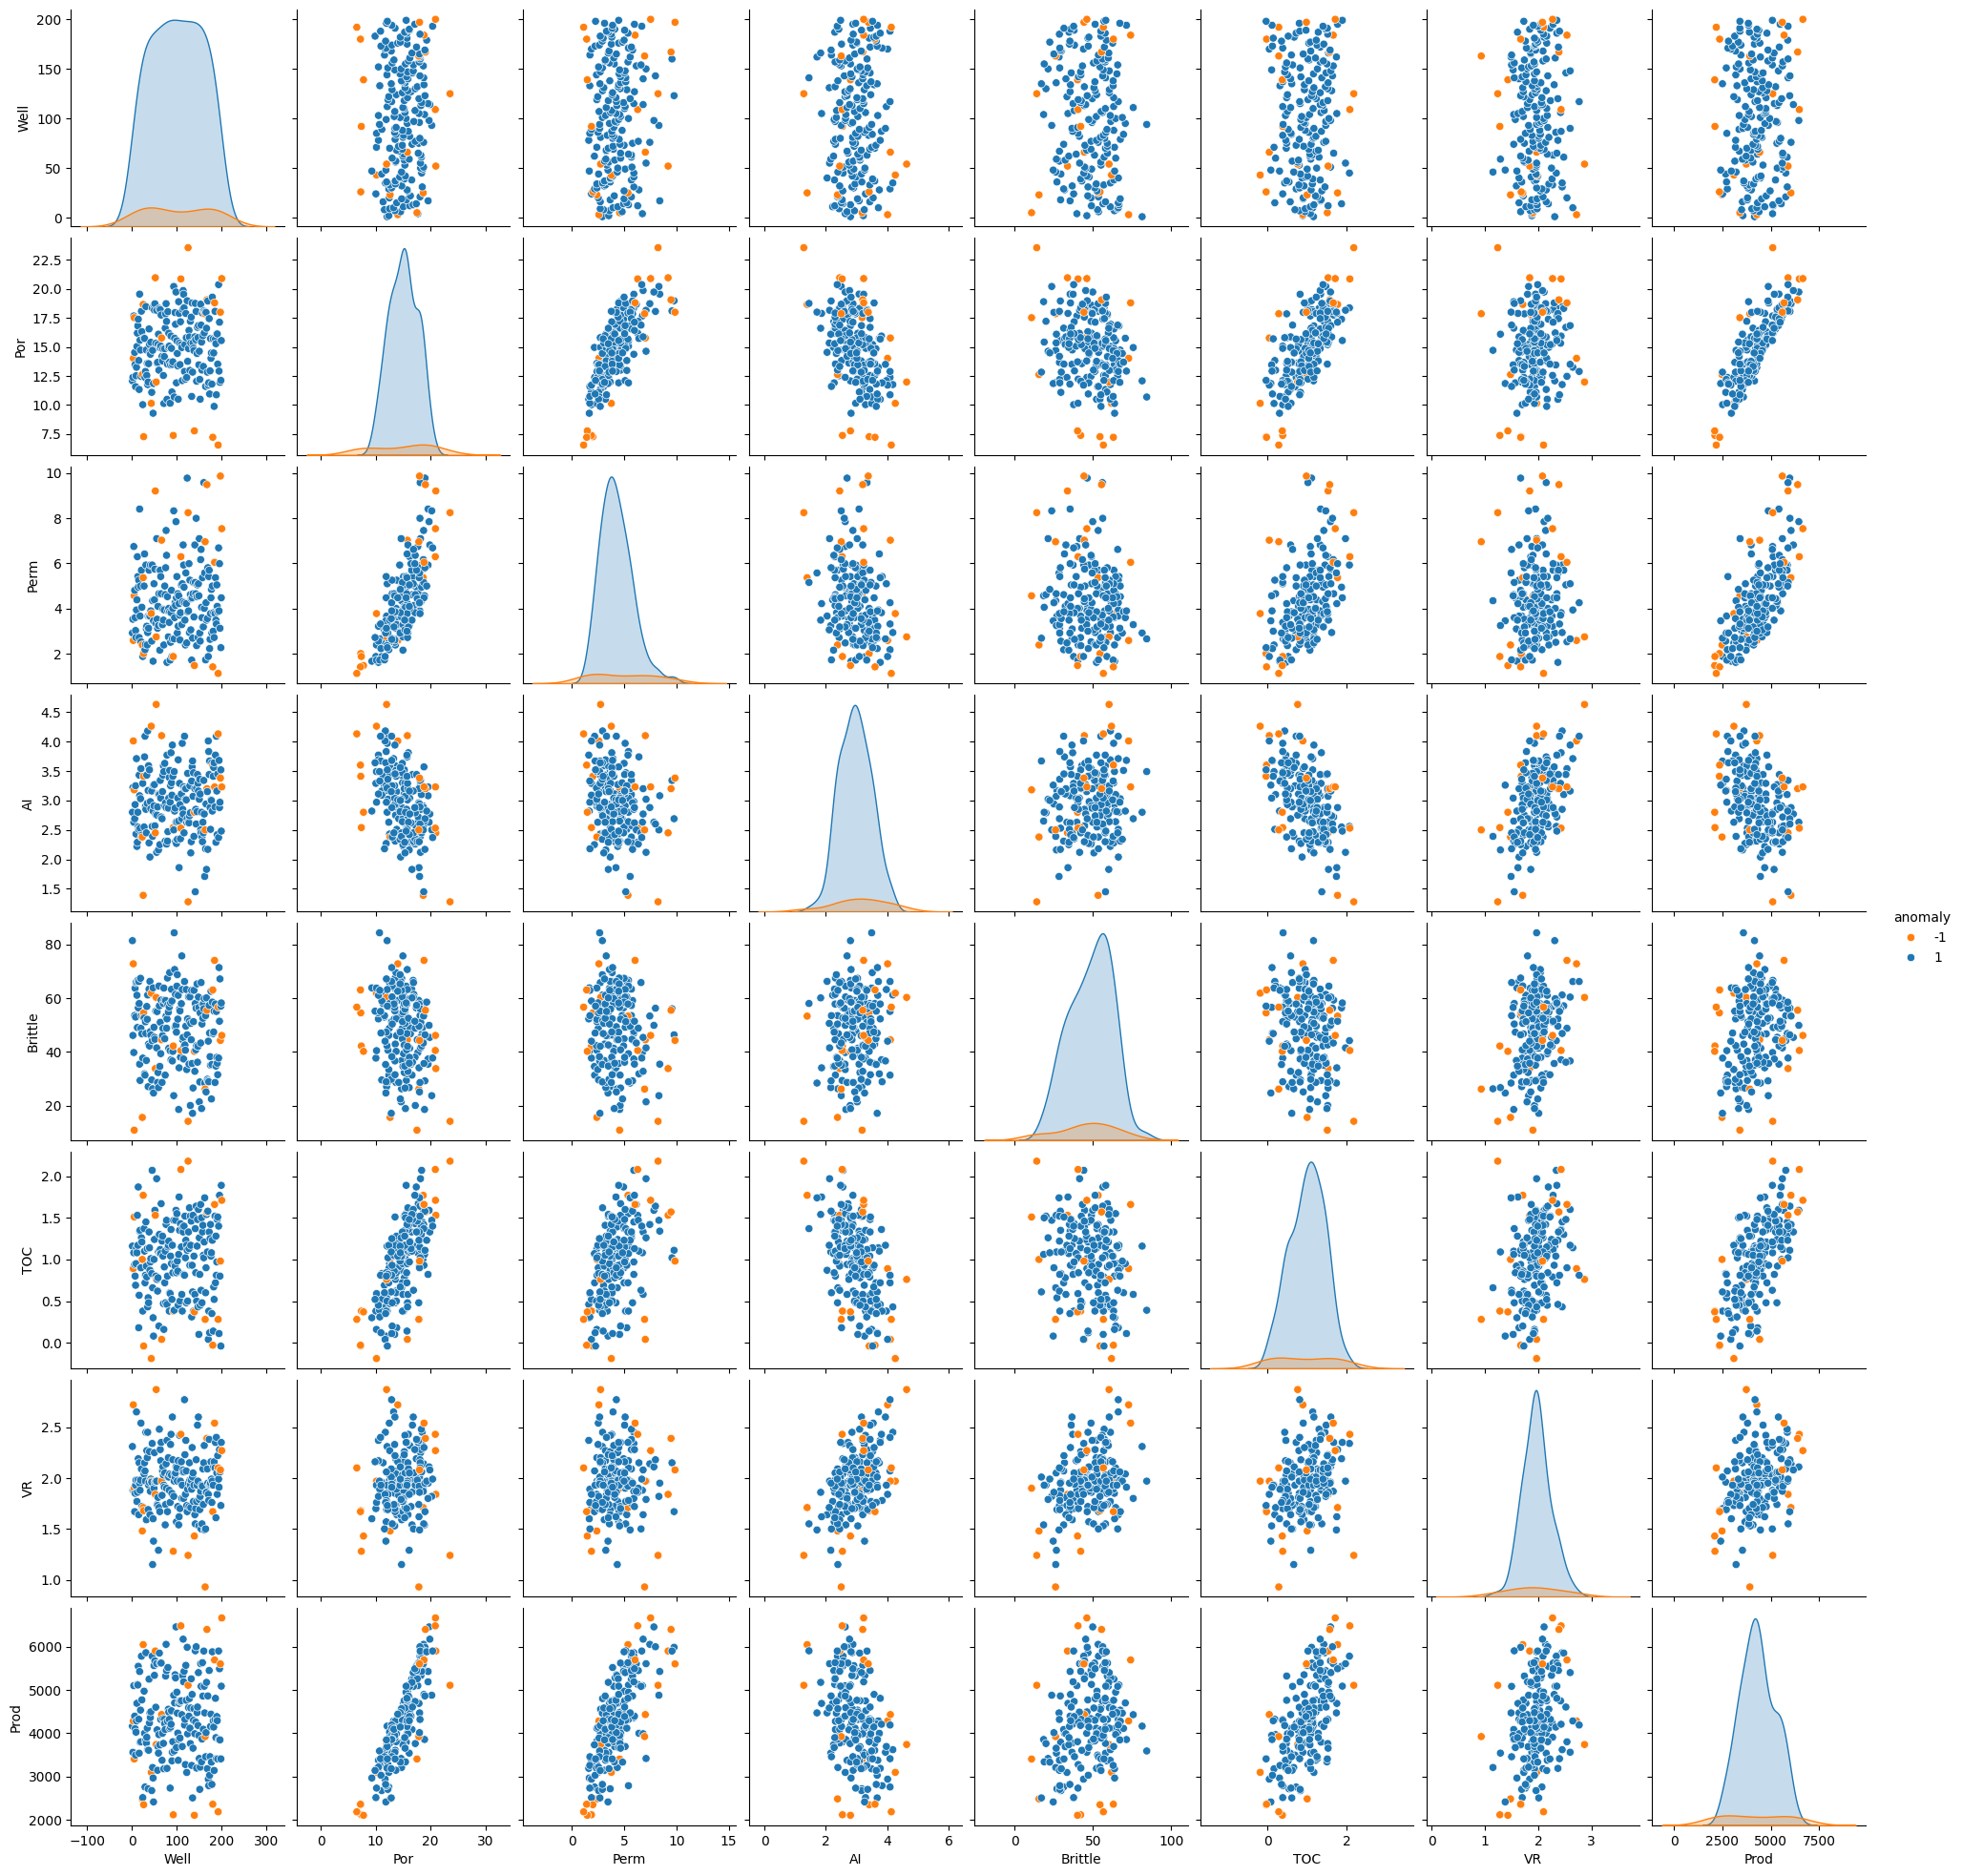

In [12]:
#call the function
outlier_plot(data, ['Isolation Forest', 'Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']);

#set the palette for the graph
palette = ['#ff7f0e', '#1f77b4']

#create a pairplot to show the outliers distribution
sns.pairplot(data,
             vars=anomaly_inputs_mx,
             hue='anomaly',
             palette=palette,
);


##### **Features Distribution**

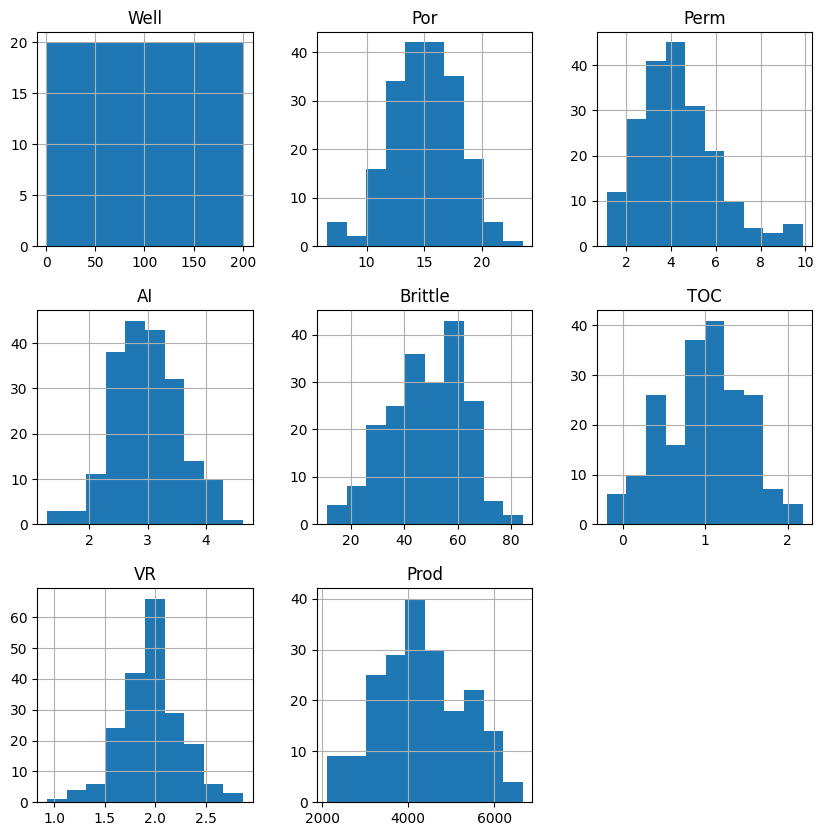

In [13]:
#create histograms to show the features spread
data.loc[:, ['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']].hist(figsize=(10, 10));

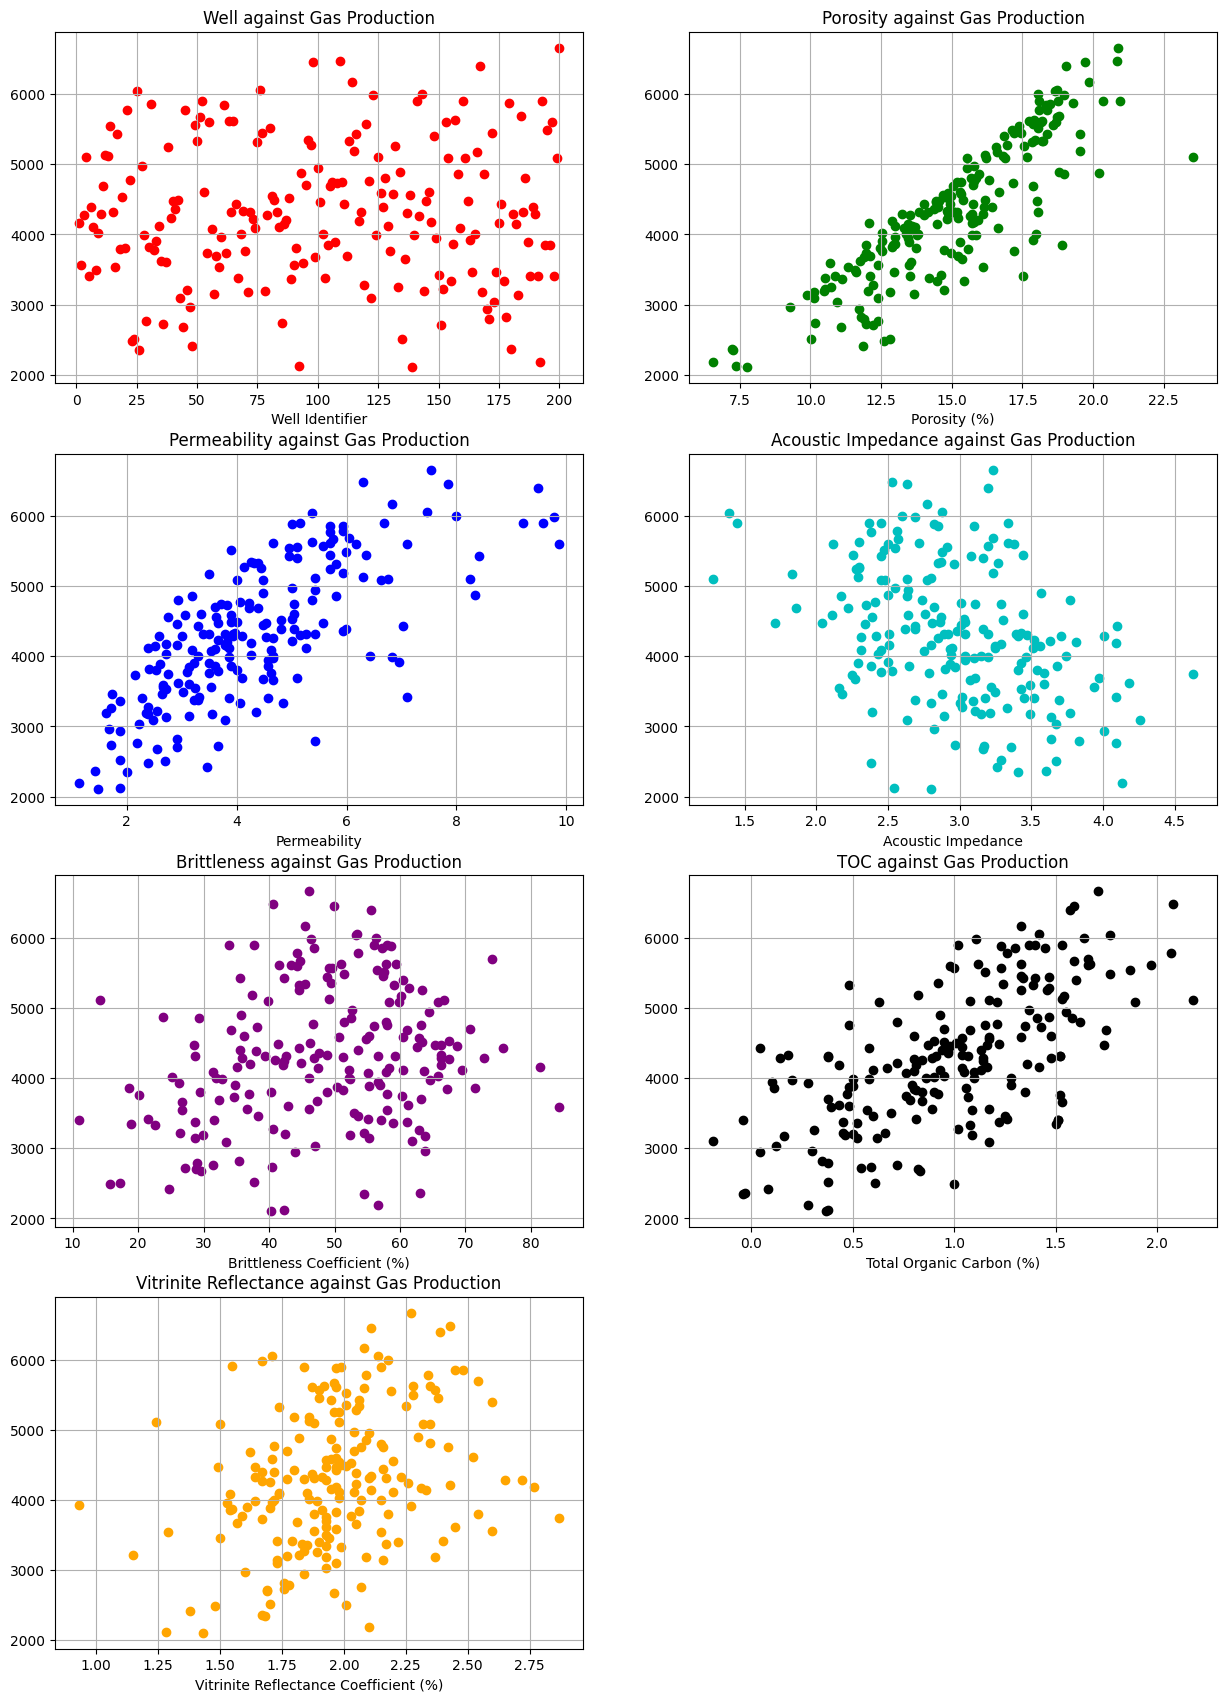

In [14]:
#create multiple scatter plot charts with features against the predictive feature
plt.rcParams['figure.figsize'] = (15, 21) 

#1st graph
plt.subplot(4,2,1)
plt.scatter(data['Well'],
            data['Prod'],
            c='red')

#set title and x-axis labels
plt.title('Well against Gas Production')
plt.xlabel('Well Identifier')
plt.grid()


#2nd graph
plt.subplot(4,2,2)
plt.scatter(data['Por'],
            data['Prod'],
            c='green')

#set title and x-axis labels
plt.title('Porosity against Gas Production')
plt.xlabel('Porosity (%)')
plt.grid()


#3rd graph
plt.subplot(4,2,3)
plt.scatter(data['Perm'],
            data['Prod'],
            c='blue')

#set title and x-axis labels
plt.title('Permeability against Gas Production')
plt.xlabel('Permeability')
plt.grid()


#4th graph
plt.subplot(4,2,4)
plt.scatter(data['AI'],
            data['Prod'],
            c='c')

#set title and x-axis labels
plt.title('Acoustic Impedance against Gas Production')
plt.xlabel('Acoustic Impedance')
plt.grid()


#5th graph
plt.subplot(4,2,5)
plt.scatter(data['Brittle'],
            data['Prod'],
            c='purple')

#set title and x-axis labels
plt.title('Brittleness against Gas Production')
plt.xlabel('Brittleness Coefficient (%)')
plt.grid()


#6th graph
plt.subplot(4,2,6)
plt.scatter(data['TOC'],
            data['Prod'],
            c='black')

#set title and x-axis labels
plt.title('TOC against Gas Production')
plt.xlabel('Total Organic Carbon (%)')
plt.grid()


#7th graph
plt.subplot(4,2,7)
plt.scatter(data['VR'],
            data['Prod'],
            c='orange')

#set title and x-axis labels
plt.title('Vitrinite Reflectance against Gas Production')
plt.xlabel('Vitrinite Reflectance Coefficient (%)')
plt.grid()

In [15]:
#drop the anomaly features
data = data.drop(['anomaly_scores', 'anomaly'],
                 axis=1,
                 errors='ignore'
                 )

**Вывод**:
- довольно чистые данные:
    - нет дубликатов
    - нет пропусков
    - по анализу Isolation Forest около 10% потенциальных выбросов
- большинство признаков распределены нормально

#### **Задание 5.1**

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты.

In [16]:
#centralize the values
centralized_matrix = data - data.mean()

#normalize the values
norm_matrix = centralized_matrix/np.linalg.norm(centralized_matrix,
                                                axis=0)

#calculate the Gram Matrix
gram_matrix = norm_matrix.T @ norm_matrix
gram_matrix

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


In [17]:
#confirm that the correlation was build correctly by using in-build methods
c_m = data.corr(numeric_only=True)
c_m

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


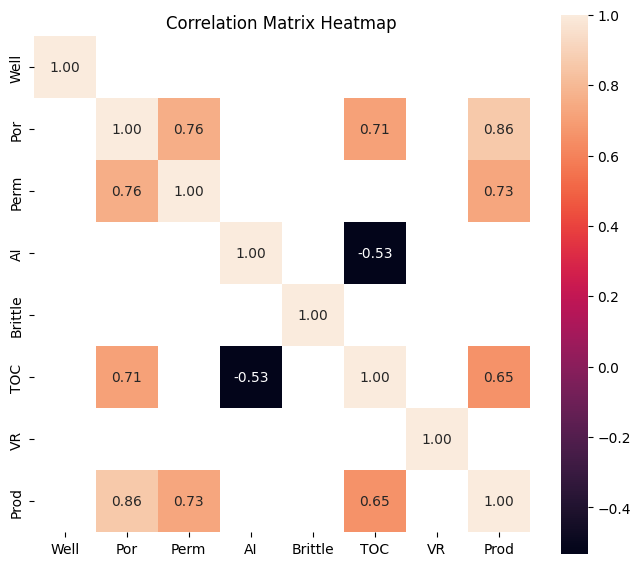

In [18]:
#set the chart size
plt.figure(figsize=(8, 7))

#create a heatmap
corr_heatmap = sns.heatmap(
    #set the correlation limits
    data=gram_matrix[gram_matrix.abs() >= 0.5],
    annot=True,
    fmt='.2f', 
    square=True,
)

#set the title
corr_heatmap.set(title='Correlation Matrix Heatmap');

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

In [19]:
#find the top 5 correlative features: use abs() to include both positive / negative correlative features
gram_matrix['Prod'].abs().sort_values(ascending=False)[1:6]

Por     0.861910
Perm    0.727426
TOC     0.654445
AI      0.390835
VR      0.323182
Name: Prod, dtype: float64

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:

* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

In [20]:
#find the rank and the determinant
print(np.linalg.matrix_rank(gram_matrix), np.linalg.det(gram_matrix), sep='\n')

8
0.0007299388072651713


In [21]:
#find the gram matrix rank and determinant
print(f'gram matrix rank: {np.linalg.matrix_rank(gram_matrix)}, gram matrix determinant: {np.linalg.det(gram_matrix):.5f}')

gram matrix rank: 8, gram matrix determinant: 0.00073


In [22]:
#write the function to execute the rouche capelli theorem
def rouche_capelli_theorem(A, b):
    #find the dimensions of the original matrix
    dimensions = A.shape
    rows, columns = dimensions
    
    #set the extended matrix
    A_ext = np.c_[A, b]
    
    #find if conditions satisfy the rouche-capelli theorem of linear algebraic system of equations
    rank_A = np.linalg.matrix_rank(A)
    rank_A_ext = np.linalg.matrix_rank(A_ext)
    
    if rank_A == rank_A_ext == columns:
        return 'conditions of rouche-capelli theorem are satisfied: rk(A) = rk(A|v) = unknown variables, thus only one solution'
    elif rank_A == rank_A_ext < columns:
        return 'conditions of rouche-capelli theorem are not satisfied: rk(A) = rk(A|v) < unknown variables, thus infinite solutions'
    elif rank_A < rank_A_ext:
        return 'conditions of rouche-capelli theorem are not satisfied: rk(A) < rk(A|v) <> unknown variables, thus unknown definite solutions'
    else:
        return 'conditions of rouche-capelli theorem are not satisfied'

In [23]:
#call the function
rouche_capelli_theorem(data, data.iloc[:, 7])

'conditions of rouche-capelli theorem are satisfied: rk(A) = rk(A|v) = unknown variables, thus only one solution'

**Вывод**:

Ранг корреляционной матрицы совпадает с количеством признаков, и на первый взкляд можно сказать, что все признаки линейно независимы, и так как определитель ≠ 0 и матрица обратима, можно считать, что в данных нет избыточности.

Однако, определитель близок к 0 (det(C) = 0.001) и присутствует высокая корреляция между двумя признаками: Porosity, пористость скважины (%) = 0.86 и Permeability, проницаемость скважины = 0.73, что предполагает о наличии мультиколлинеарности.

То есть, если воспользоваться и строить модель линейной регрессии по методу наименьших квадратов, потенциальная высокая зависимость между признаками усложнит интерпретацию параметров.

#### **Задание 5.2**

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.


In [24]:
#write the function to execute the rouche capelli theorem
def rouche_capelli_theorem(A, b):
    #find the dimensions of the original matrix
    dimensions = A.shape
    rows, columns = dimensions
    
    #set the extended matrix
    A_ext = np.c_[A, b]
    
    #find if conditions satisfy the rouche-capelli theorem of linear algebraic system of equations
    rank_A = np.linalg.matrix_rank(A)
    rank_A_ext = np.linalg.matrix_rank(A_ext)
    
    if rank_A == rank_A_ext == columns:
        return 'conditions of rouche-capelli theorem are satisfied: rk(A) = rk(A|v) = unknown variables, thus only one solution'
    elif rank_A == rank_A_ext < columns:
        return 'conditions of rouche-capelli theorem are not satisfied: rk(A) = rk(A|v) < unknown variables, thus infinite solutions'
    elif rank_A < rank_A_ext:
        return 'conditions of rouche-capelli theorem are not satisfied: rk(A) < rk(A|v) <> unknown variables, thus unknown definite solutions'
    else:
        return 'conditions of rouche-capelli theorem are not satisfied'
    

def rouche_capelli_solution(A, b):
    #find the inverse matrix
    A_1 = np.linalg.inv(A)
    
    #find the scalar product, thus solutions for unknown variables
    solution = np.dot(A_1, b)
    
    return solution


def find_best_approximation_error(A, b, w):
    #find the best approximation
    b_hat = np.dot(A, w)
    
    #find the error
    error = b - b_hat
    
    #convert matrix to list
    error = error.tolist()
    
    #flatten the list
    import itertools
    error = list(itertools.chain(*error))
    
    #find the error_length
    total = []
    for n in error:
        n = n**2
        total.append(n)
    
    return (f'√{sum(total)} = {np.round(np.sqrt(sum(total)), 5)}, error_coordinates = {error}')


def find_w(A, b):
    #find A_T by A: transposed original matrix by original matrix
    At_A = np.dot(A.T, A)
    
    #find A_T by b: transposed original matrix by vector b
    At_b = np.dot(A.T, b).T
    
    return rouche_capelli_solution(At_A, At_b)

In [25]:
#select the features
X = np.column_stack((
        np.ones(data.shape[0]), 
        data.iloc[:, :-1].values)
)

y = data['Prod']

#find Ordinary Least Squares (OLS) coefficients
solution_coef = find_w(X, y)
print(solution_coef)
print()
print(np.round(solution_coef, 0))

[-1.23230803e+03  5.07003631e-02  2.30179140e+02  1.16239006e+02
 -3.65202301e+02  2.49943700e+01 -7.84009294e+01  7.85259815e+02]

[-1232.     0.   230.   116.  -365.    25.   -78.   785.]


In [26]:
#confirm the calculation
w_hat = np.linalg.inv(X.T@X) @ X.T@y
print(w_hat)
print()
print(np.round(w_hat, 0))

[-1.23230803e+03  5.07003631e-02  2.30179140e+02  1.16239006e+02
 -3.65202301e+02  2.49943700e+01 -7.84009294e+01  7.85259815e+02]

[-1232.     0.   230.   116.  -365.    25.   -78.   785.]


In [27]:
#display the results
ols_coef = pd.DataFrame(data=np.round(solution_coef, 2),
                        index=np.hstack((['Intercept'],
                                         list(data.columns)[0:7])
                        ),
                        columns = ['OLS_Coefficients']
)

ols_coef

,OLS_Coefficients
Intercept,-1232.31
Well,0.05
Por,230.18
Perm,116.24
AI,-365.20
Brittle,24.99
TOC,-78.40
VR,785.26


Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.

**Вывод**:

Анализ показывает наличие неинформативных признаков (Well), которые маловероятно как-либо влияют на вычисление целевого признака (Gas Production), и коэффициентов с положительными и отрицательными значениями.

Наибольшее влияние производит признак - Porosity в сторону увеличения, а признак Acoustic Impedance соответственно в сторону убывания.

Коэффициенты с отрицательными значениями - Acoustic Impedance, Total Organic Carbon - предполагают отрицательную или обратную связь между независимой переменной и зависимой переменной. То есть по мере увеличения Acoustic Impedance или Total Organic Carbon, Gas Production будет иметь тенденцию к уменьшению, а по мере уменьшения Acoustic Impedance или Total Organic Carbon, Gas Production будет иметь тенденцию к увеличению.

Положительная линейная связь означает, что если одна переменная увеличивается, то и другая переменная увеличивается.
То есть по мере увеличения Porosity, Permeability, Brittleness, или Vitrinite Reflectance, Gas Production будет иметь тенденцию к увеличению, а по мере уменьшения этих факторов, целевая переменная будет иметь тенденцию к уменьшению.

#### **Задание 5.3**

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

In [28]:
#new observations
x_new = np.array([1, 106, 15.32, 3.71, 3.29, 55.99, 1.35, 2.42])

#new predictive value
y_new = 4748.315024

#calculate the predictive value
y_new_pred = np.round(x_new@solution_coef, 6)
print(f'Gas Production Forecast on New Observations: {y_new_pred}')
print (f'Absolute Gas Production Error: {np.round(np.abs(y_new - y_new_pred), 6)}')

Gas Production Forecast on New Observations: 4723.064054
Absolute Gas Production Error: 25.25097


In [29]:
#calculate the metrics
y_pred = X@solution_coef
print(f'MAPE: {(metrics.mean_absolute_percentage_error(y, y_pred) * 100):.3f}%')
print(f'R2: {(metrics.r2_score(y, y_pred) * 100):.3f}%')

MAPE: 3.628%
R2: 95.985%


**Вывод**:

Более низкие значения MAPE и высокие значения R2-Score указывают на более высокую точность модели.

Однако, как минимум между двумя признаками: Porosity, пористость скважины (%) и Permeability, проницаемость скважины - высокая корреляция, а мультиколлинеарность подрывает статистическую значимость независимых переменных, не позволяя уверено оценить признаки по отдельности.

#### **Задание 5.4**

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

In [30]:
#merge the results of the correlative matrix and the coefficients results of OLS
merged_corr = pd.merge(gram_matrix['Prod'][:-1], ols_coef[1:],
                       left_index=True, right_index=True)

#rename the columns
merged_corr = merged_corr.rename(columns={'Prod': 'Correlation',
                                'OLS_Coefficients': 'Coefficients',                               
})

#display
merged_corr

,Correlation,Coefficients
Well,0.026817,0.05
Por,0.861910,230.18
Perm,0.727426,116.24
AI,-0.390835,-365.20
Brittle,0.237155,24.99
TOC,0.654445,-78.40
VR,0.323182,785.26


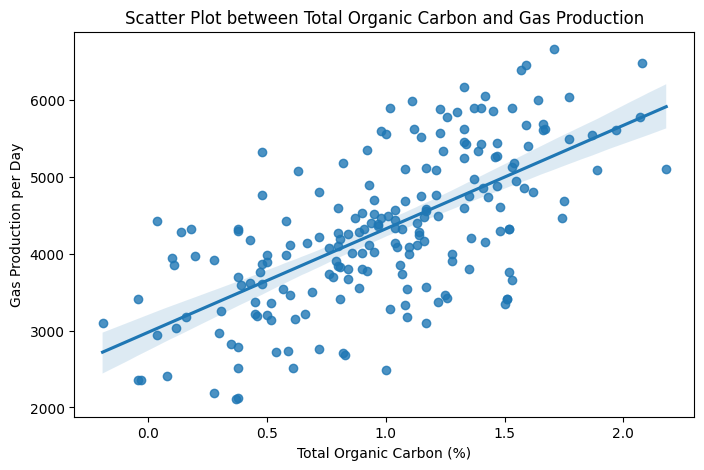

In [31]:
#set the chart size
plt.subplots(figsize=(8, 5))

#create the scatter plot
fig = sns.regplot(data,
                  x='TOC',
                  y='Prod')

fig.set(title='Scatter Plot between Total Organic Carbon and Gas Production',
        xlabel='Total Organic Carbon (%)',
        ylabel='Gas Production per Day');

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Вывод**:

Диаграмма рассеяния показывает положительную линейную зависимость между total organic carbon и прогнозируемым значением - gas production, таким образом, исходные данные предполагают, что, если один фактор увеличивается, то увеличивается и другой. \
Корреляционное значение также показывает умеренно сильную связь между факторами - 0,65.

Однако значение коэффициента отрицательно, что говорит о том, что total organic carbon отрицательно влияет на gas production, что казалось бы по предыдущим исследованиям не совсем логично. \
Потенциально, из-за высокой коллиарности между признаками коэффициент не рассчитан правильно из-за этой линейной зависимости, поэтому может в будущем повлияет на точность регрессионной модели.

#### **Задание 5.5**

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики).

In [32]:
#find the moderately strong correlative features
np.round(gram_matrix[(gram_matrix.abs()>=0.5) & (gram_matrix.abs() < 1)], 2)

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Por,NaN,NaN,0.76,NaN,NaN,0.71,NaN,0.86
Perm,NaN,0.76,1.00,NaN,NaN,NaN,NaN,0.73
AI,NaN,NaN,NaN,1.00,NaN,-0.53,NaN,NaN
Brittle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOC,NaN,0.71,NaN,-0.53,NaN,NaN,NaN,0.65
VR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prod,NaN,0.86,0.73,NaN,NaN,0.65,NaN,1.00


Well показывает корреляцию менее 0,05. \
[Porosity](https://www.petrosync.com/blog/what-is-porosity/) считается более ценной для добычи газа, поэтому любые сильно коррелирующие с Porosity признаки, такие как Permeability и Total Organic Carbon, следует удалить.

In [33]:
#delete uninformative or highly correlative features
data = data.drop(['Well', 'Perm', 'TOC'],
                 axis=1,
                 errors='ignore')

In [34]:
#select the features
X = np.column_stack((
        np.ones(data.shape[0]), 
        data.iloc[:, :-1].values)
)

y = data['Prod']

#find Ordinary Least Squares (OLS) coefficients
solution_coef_updated = find_w(X, y)
print(solution_coef_updated)
print()
print(np.round(solution_coef_updated, 0))

[-1835.44646069   293.03624565  -200.03091206    27.64098209
   517.40272597]

[-1835.   293.  -200.    28.   517.]


In [35]:
#display the results
ols_coef_updated = pd.DataFrame(data=np.round(solution_coef_updated, 2),
                                index=np.hstack((['Intercept'],
                                                 list(data.columns)[0:4])
                                                ),
                                columns = ['New_Coefficients']
)

ols_coef_updated

,New_Coefficients
Intercept,-1835.45
Por,293.04
AI,-200.03
Brittle,27.64
VR,517.40


In [36]:
#merge the results of old and new coefficients
merged_new = pd.merge(ols_coef, ols_coef_updated,
                      left_index=True, right_index=True)

#rename the columns
merged_new = merged_new.rename(columns={'OLS_Coefficients': 'Old_Coefficients',                               
})

#display
merged_new

,Old_Coefficients,New_Coefficients
Intercept,-1232.31,-1835.45
Por,230.18,293.04
AI,-365.20,-200.03
Brittle,24.99,27.64
VR,785.26,517.40


In [37]:
#merge the results of the correlative matrix and the coefficients results of OLS
merged_corr_updated = pd.merge(data.corr()['Prod'][:-1], ols_coef_updated[1:],
                               left_index=True, right_index=True)

#rename the columns
merged_corr_updated = merged_corr_updated.rename(columns={'Prod': 'Correlation',
})

#display
merged_corr_updated

,Correlation,New_Coefficients
Por,0.861910,293.04
AI,-0.390835,-200.03
Brittle,0.237155,27.64
VR,0.323182,517.40


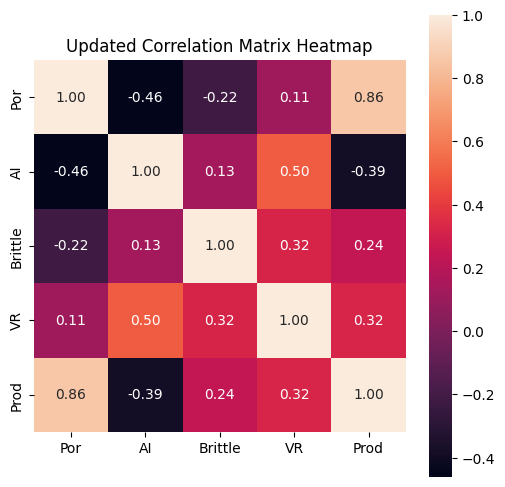

In [38]:
#set the chart size
plt.figure(figsize=(6, 6))

#create a heatmap
corr_heatmap_updated = sns.heatmap(
    data=data.corr(),
    annot=True,
    fmt='.2f', 
    square=True,
)

#set the title
corr_heatmap_updated.set(title='Updated Correlation Matrix Heatmap');

In [39]:
#remove the predictive feature from the correlation matrix
sliced = data.corr().iloc[:, :-1].iloc[:-1 , :]

#find the new matrix rank and determinant
print(f'new matrix rank: {np.linalg.matrix_rank(sliced)}, mew matrix determinant: {np.linalg.det(sliced):.5f}')

new matrix rank: 4, mew matrix determinant: 0.36826


In [40]:
#calculate the metrics
y_pred_new = X@solution_coef_updated
print(f'MAPE: {(metrics.mean_absolute_percentage_error(y, y_pred_new) * 100):.3f}%')
print(f'R2: {(metrics.r2_score(y, y_pred_new) * 100):.3f}%')

MAPE: 4.044%
R2: 94.520%


Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Вывод**:

Трудно сказать, оказало ли удаление высококоррелированных признаков огромное влияние на модель в целом, так как трудно уверено утверждать оказывает ли уменьшение или увеличение значения определенного коэффициента огромное влияние на точность модели или нет, так модель еще не используется на реальных данных, но, по крайней мере, изменение метрик: MAPE с 3,628% до 4,044% и R2-Score с 95,985% до 94,52% указывают, что по крайней мере, модель на пути к стабилизации.

Кроме того, новый определитель не так близок от 0 — с 0,001 до 0,368 — что показывает снижение вероятности зависимости оставшихся признаков, и вероятность улучшения точности модели.

#### **Задание 5.6**

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

In [41]:
#create the object class
lin_reg = linear_model.LinearRegression(fit_intercept=False)

#model learning
lin_reg.fit(X, y)

#make a prediction
y_pred_lin_reg = lin_reg.predict(X)

print(f'MAPE: {(metrics.mean_absolute_percentage_error(y, y_pred_lin_reg) * 100):.3f} %')
print(f'R2: {(metrics.r2_score(y, y_pred_lin_reg) * 100):.3f}%')

MAPE: 4.044 %
R2: 94.520%


In [42]:
#display the results
lin_reg_coef = pd.DataFrame(data=np.round(lin_reg.coef_, 2),
                            index=np.hstack((['Intercept'],
                                             list(data.columns)[:-1])
                                            ),
                            columns = ['Model_Coefficients']
)

lin_reg_coef

,Model_Coefficients
Intercept,-1835.45
Por,293.04
AI,-200.03
Brittle,27.64
VR,517.40


In [43]:
#merge the results of the correlative matrix and the coefficients results of OLS
merged_coef = pd.merge(lin_reg_coef, ols_coef_updated,
                       left_index=True, right_index=True)

#rename the columns
merged_coef = merged_coef.rename(columns={'New_Coefficients': 'Manual_Coefficients',
})

#display
merged_coef

,Model_Coefficients,Manual_Coefficients
Intercept,-1835.45,-1835.45
Por,293.04,293.04
AI,-200.03,-200.03
Brittle,27.64,27.64
VR,517.40,517.40


**Вывод**:

Нет разницы между коэффициентами, созданными вручную путём матричных формул и автоматической моделью с помошью *scikit-learn*, соответственно и метрики неразличимы.

Можно утверждать, что алгоритм из внутренних библиотек построен на тех же формулах, что и метод наишеньших квадратов.

### **Практика**:
### **Полиномиальная Регрессия и Регуляризация**

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию.

#### **Задание 8.1**

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [44]:
from collections import OrderedDict

#create an ordered dict to store model results
review = OrderedDict([
    ('model_name', []),
    ('hyperparameters', []), 
    ('polynomization', []), 
    ('MAPE%, train', []), 
    ('MAPE%, test', [])
    ]
)

In [45]:
#initialize the object class
ss_scaler = preprocessing.StandardScaler()

#scale the features, but without the 'ones' vector
X_scaled = ss_scaler.fit_transform(X[:, 1:])

#create polynomial features
poly_feat = preprocessing.PolynomialFeatures(degree=3,
                                             include_bias=False)

X_poly_feat = poly_feat.fit_transform(X_scaled)

print(f'New Dimensions: {X_poly_feat.shape}')

New Dimensions: (200, 34)


In [46]:
def cv_metrics(model, A, v, cv=5, scoring='neg_mean_absolute_percentage_error', return_train_score=True, n_jobs=-1):
    cv_metrics = model_selection.cross_validate(
        estimator=model, #predictive model
        X=A, #observations
        y=v, #predictive value
        cv=5, #cross-folds
        scoring='neg_mean_absolute_percentage_error',
        #calculate metrics on train folds
        return_train_score=True,
        n_jobs=-1
    )
    
    #calculate the metrics
    model_cv_train = cv_metrics['train_score'].mean() * 100
    model_cv_test = cv_metrics['test_score'].mean() * 100
    
    print('train data:')
    print(f'MAPE: {-model_cv_train:.3f}%')
    print()
    print('test data:')
    print(f'MAPE: {-model_cv_test:.3f}%')
    
    #add model results to the ordered dict
    review['model_name'].append(model.__class__.__name__)
    review['MAPE%, train'].append(round(-model_cv_train, 2))
    review['MAPE%, test'].append(round(-model_cv_test, 2))

In [47]:
#calculate the metrics on linear regression model
cv_metrics(lin_reg, X, y)

#add model results to the ordered dict
review['hyperparameters'].append('without selection of hyperparameters')
review['polynomization'].append('False')

train data:
MAPE: 4.021%

test data:
MAPE: 4.231%


In [48]:
#calculate the metrics on linear regression model with polynomial features, and fit_intercept=True
cv_metrics(model=linear_model.LinearRegression(), A=X_poly_feat, v=y)

#add model results to the ordered dict
review['hyperparameters'].append('without selection of hyperparameters')
review['polynomization'].append('True')

train data:
MAPE: 1.773%

test data:
MAPE: 2.681%


In [49]:
#show intermediate model results
pd.DataFrame(review)

,model_name,hyperparameters,polynomization,"MAPE%, train","MAPE%, test"
0,LinearRegression,without selection of hyperparameters,False,4.02,4.23
1,LinearRegression,without selection of hyperparameters,True,1.77,2.68


**Вывод**:

Используя полиномиальные признаки, модель может улавливать нелинейные связи между признаками и целевой переменной.

В то время как стандартизированные данные помогают центрировать распределение, что может ускорить процесс обучения и предотвратить смещение из-за признаков с большими значениями, тем самым делая модель более точной в прогнозировании результатов.

С использованием полиномиальных признаков метрики - MAPE(%) на обучающих данных улучшились в 2,27 раза, а на тестовых данных в 1,58 раза.

#### **Задание 8.2**

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [50]:
#create a function for optuna study
def optuna_lasso_reg(trial):
  #set hyperparameters
  grid = {
    'alpha': trial.suggest_float('alpha', 1, 10, step=0.5),
  }
  
  model = linear_model.Lasso(
    **grid,
    random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
      model,
      X=X_poly_feat,
      y=y,
      scoring='neg_mean_absolute_percentage_error',
      cv=5,
      n_jobs=-1,
      ).mean()
  
  return abs(score)

In [51]:
%%time

#begin hyperparameters selection
#create review object
study_optuna_lasso_lin_reg = optuna.create_study(
    study_name='LassoRegression',
    direction='minimize',
    )

#search for the best combination
study_optuna_lasso_lin_reg.optimize(optuna_lasso_reg,
                                    n_trials=20)

[I 2024-08-31 01:21:38,125] A new study created in memory with name: LassoRegression
[I 2024-08-31 01:21:38,142] Trial 0 finished with value: 0.022764846761246283 and parameters: {'alpha': 4.5}. Best is trial 0 with value: 0.022764846761246283.
[I 2024-08-31 01:21:38,157] Trial 1 finished with value: 0.02298509516022699 and parameters: {'alpha': 3.5}. Best is trial 0 with value: 0.022764846761246283.
[I 2024-08-31 01:21:38,663] Trial 2 finished with value: 0.023612541000914693 and parameters: {'alpha': 9.5}. Best is trial 0 with value: 0.022764846761246283.
[I 2024-08-31 01:21:38,676] Trial 3 finished with value: 0.0231764805153545 and parameters: {'alpha': 8.0}. Best is trial 0 with value: 0.022764846761246283.
[I 2024-08-31 01:21:38,690] Trial 4 finished with value: 0.022921445282042336 and parameters: {'alpha': 7.0}. Best is trial 0 with value: 0.022764846761246283.
[I 2024-08-31 01:21:38,706] Trial 5 finished with value: 0.022842255999261044 and parameters: {'alpha': 4.0}. Best is 

CPU times: user 102 ms, sys: 21.4 ms, total: 124 ms
Wall time: 811 ms


In [52]:
#display best hyperparameters
print(f'best hyperparameters with lasso using optuna {study_optuna_lasso_lin_reg.best_params}')

best hyperparameters with lasso using optuna {'alpha': 5.0}


In [53]:
#set the model with the best parameters
model_opt_lasso = linear_model.Lasso(
    **study_optuna_lasso_lin_reg.best_params,
    random_state=42
    )

#calculate the metrics
cv_metrics(model_opt_lasso, A=X_poly_feat, v=y)

#add model results to the ordered dict
review['hyperparameters'].append(study_optuna_lasso_lin_reg.best_params)
review['polynomization'].append('True')

train data:
MAPE: 1.828%

test data:
MAPE: 2.276%


In [54]:
#show intermediate model results
pd.DataFrame(review)

,model_name,hyperparameters,polynomization,"MAPE%, train","MAPE%, test"
0,LinearRegression,without selection of hyperparameters,False,4.02,4.23
1,LinearRegression,without selection of hyperparameters,True,1.77,2.68
2,Lasso,{'alpha': 5.0},True,1.83,2.28


**Вывод**:

Обучение модели на стандартизированных полиномиальных признаках с выбранными гиперпараметрами для alpha с помощью optuna.

Лучшим параметром для alpha для Lasso в итоге значение 5, в 5 раз больше значения по умолчанию 1.

Метрики на обучающих данных немного хуже при использовании регуляризации, однако лучше на тестовых данных.

#### **Задание 8.3**

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [55]:
#create a function for optuna study
def optuna_ridge_reg(trial):
  #set hyperparameters
  grid = {
    'alpha': trial.suggest_float('alpha', 1, 10, step=0.5),
  }
  
  model = linear_model.Ridge(
    **grid,
    random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
      model,
      X=X_poly_feat,
      y=y,
      scoring='neg_mean_absolute_percentage_error',
      cv=5,
      n_jobs=-1,
      ).mean()
  
  return abs(score)

In [56]:
%%time

#begin hyperparameters selection
#create review object
study_optuna_ridge_lin_reg = optuna.create_study(
    study_name='LidgeRegression',
    direction='minimize',
    )

#search for the best combination
study_optuna_ridge_lin_reg.optimize(optuna_ridge_reg,
                                    n_trials=20)

[I 2024-08-31 01:21:39,001] A new study created in memory with name: LidgeRegression
[I 2024-08-31 01:21:39,017] Trial 0 finished with value: 0.03124859142587693 and parameters: {'alpha': 4.5}. Best is trial 0 with value: 0.03124859142587693.
[I 2024-08-31 01:21:39,032] Trial 1 finished with value: 0.036426046009871885 and parameters: {'alpha': 8.5}. Best is trial 0 with value: 0.03124859142587693.
[I 2024-08-31 01:21:39,047] Trial 2 finished with value: 0.027658668281966593 and parameters: {'alpha': 1.5}. Best is trial 2 with value: 0.027658668281966593.
[I 2024-08-31 01:21:39,062] Trial 3 finished with value: 0.027167779450929918 and parameters: {'alpha': 1.0}. Best is trial 3 with value: 0.027167779450929918.
[I 2024-08-31 01:21:39,078] Trial 4 finished with value: 0.03581441347694493 and parameters: {'alpha': 8.0}. Best is trial 3 with value: 0.027167779450929918.
[I 2024-08-31 01:21:39,093] Trial 5 finished with value: 0.03453340974302698 and parameters: {'alpha': 7.0}. Best is tr

CPU times: user 101 ms, sys: 19.6 ms, total: 120 ms
Wall time: 320 ms


In [57]:
#display best hyperparameters
print(f'best hyperparameters with ridge using optuna {study_optuna_ridge_lin_reg.best_params}')

best hyperparameters with ridge using optuna {'alpha': 1.0}


In [58]:
#set the model with the best parameters
model_opt_ridge = linear_model.Ridge(
    **study_optuna_ridge_lin_reg.best_params,
    random_state=42
    )

#calculate the metrics
cv_metrics(model_opt_ridge, A=X_poly_feat, v=y)

#add model results to the ordered dict
review['hyperparameters'].append(study_optuna_ridge_lin_reg.best_params)
review['polynomization'].append('True')

train data:
MAPE: 1.826%

test data:
MAPE: 2.717%


In [59]:
#show intermediate model results
pd.DataFrame(review)

,model_name,hyperparameters,polynomization,"MAPE%, train","MAPE%, test"
0,LinearRegression,without selection of hyperparameters,False,4.02,4.23
1,LinearRegression,without selection of hyperparameters,True,1.77,2.68
2,Lasso,{'alpha': 5.0},True,1.83,2.28
3,Ridge,{'alpha': 1.0},True,1.83,2.72


**Вывод**:

Обучение модели на стандартизированных полиномиальных признаках с выбранными гиперпараметрами для alpha с помощью optuna.

Лучшим параметром для alpha для Ridge в итоге значение 1, то есть значение по умолчанию 1.

Метрики на обучающих (1.83) и тестовых данных (2.72 > 2.28) не показали улучшение, что говорит о том, что скорее всего с $L_1$-регуляризацией предсказания лучше, чем со $L_2$.

Смысл в этом есть, так как Lasso, как правило, хорошо работает, если количество значимых параметров небольшое, Ridge же, как правило, благоприятствует модели с большим количеством параметров, поскольку сокращает менее важные коэффициенты, но сохраняет их в модели.

#### **Задание 8.4**

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [60]:
#create a function for optuna study with baseline penalties
def optuna_elastic_net_reg(trial):
  #set hyperparameters
  grid = {
    'alpha': trial.suggest_float('alpha', 1, 10, step=0.5),
    'l1_ratio': trial.suggest_float('l1_ratio', 0.1, 1, step=0.05),
  }
  
  model = linear_model.ElasticNet(
    **grid,
    random_state=42)
  
  #model learning through cross-validation
  score = model_selection.cross_val_score(
      model,
      X=X_poly_feat,
      y=y,
      scoring='neg_mean_absolute_percentage_error',
      cv=5,
      n_jobs=-1,
      ).mean()
  
  return abs(score)

In [61]:
%%time

#begin hyperparameters selection
#create review object
study_optuna_elastic_net_lin_reg = optuna.create_study(
    study_name='ElasticNetRegression',
    direction='minimize',
    )

[I 2024-08-31 01:21:39,386] A new study created in memory with name: ElasticNetRegression


CPU times: user 600 µs, sys: 489 µs, total: 1.09 ms
Wall time: 691 µs


In [62]:
#search for the best combination
study_optuna_elastic_net_lin_reg.optimize(optuna_elastic_net_reg,
                                          n_trials=20)

[I 2024-08-31 01:21:39,404] Trial 0 finished with value: 0.0681431665782973 and parameters: {'alpha': 2.5, 'l1_ratio': 0.85}. Best is trial 0 with value: 0.0681431665782973.
[I 2024-08-31 01:21:39,419] Trial 1 finished with value: 0.09158496018844112 and parameters: {'alpha': 2.5, 'l1_ratio': 0.55}. Best is trial 0 with value: 0.0681431665782973.
[I 2024-08-31 01:21:39,435] Trial 2 finished with value: 0.0877578392345165 and parameters: {'alpha': 6.0, 'l1_ratio': 0.85}. Best is trial 0 with value: 0.0681431665782973.
[I 2024-08-31 01:21:39,449] Trial 3 finished with value: 0.11563451320624556 and parameters: {'alpha': 5.5, 'l1_ratio': 0.30000000000000004}. Best is trial 0 with value: 0.0681431665782973.
[I 2024-08-31 01:21:39,465] Trial 4 finished with value: 0.09578770160075671 and parameters: {'alpha': 2.0, 'l1_ratio': 0.30000000000000004}. Best is trial 0 with value: 0.0681431665782973.
[I 2024-08-31 01:21:39,480] Trial 5 finished with value: 0.08953471733558882 and parameters: {'al

In [63]:
#display best hyperparameters
print(f'best hyperparameters with elastic net using optuna {study_optuna_elastic_net_lin_reg.best_params}')

best hyperparameters with elastic net using optuna {'alpha': 4.0, 'l1_ratio': 1.0}


In [64]:
#set the model with the best parameters
model_opt_elastic_net = linear_model.ElasticNet(
    **study_optuna_elastic_net_lin_reg.best_params,
    random_state=42
    )

#calculate the metrics
cv_metrics(model_opt_elastic_net, A=X_poly_feat, v=y)

#add model results to the ordered dict
review['hyperparameters'].append(study_optuna_elastic_net_lin_reg.best_params)
review['polynomization'].append('True')

train data:
MAPE: 1.813%

test data:
MAPE: 2.284%


In [65]:
#show intermediate model results
pd.DataFrame(review)

,model_name,hyperparameters,polynomization,"MAPE%, train","MAPE%, test"
0,LinearRegression,without selection of hyperparameters,False,4.02,4.23
1,LinearRegression,without selection of hyperparameters,True,1.77,2.68
2,Lasso,{'alpha': 5.0},True,1.83,2.28
3,Ridge,{'alpha': 1.0},True,1.83,2.72
4,ElasticNet,"{'alpha': 4.0, 'l1_ratio': 1.0}",True,1.81,2.28


**Вывод**:

Обучение модели на стандартизированных полиномиальных признаках с выбранными гиперпараметрами для alpha и l1_ratio с помощью optuna.

Лучшим параметром для alpha в итоге значение 4, в 4 раза больше значения по умолчанию 1, а для l1_ratio = 1, что в 2 раза больше значения по умолчанию 0.5.

Метрики на обучающих данных немного лучше при использовании регуляризации (1.81 < 1.83), и примерно те же на тестовых данных (2.28).

Elastic Net хорош при обрабатывании мультиколлинеарности, так как группирует коррелированные признаки и выбирает наиболее показательные из них, однако, так как самые коллиреарные признаки были удалены из данных до построения модели, результаты не особенно улучшились по сравнению с использованием $L_1$-регуляризации. 

#### **Задание 8.5**

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

In [66]:
#convert ordered dict to dataframe, and hope for the best
review_results = pd.DataFrame(review)
review_results

,model_name,hyperparameters,polynomization,"MAPE%, train","MAPE%, test"
0,LinearRegression,without selection of hyperparameters,False,4.02,4.23
1,LinearRegression,without selection of hyperparameters,True,1.77,2.68
2,Lasso,{'alpha': 5.0},True,1.83,2.28
3,Ridge,{'alpha': 1.0},True,1.83,2.72
4,ElasticNet,"{'alpha': 4.0, 'l1_ratio': 1.0}",True,1.81,2.28


# **Вывод**:

Модель линейной регрессии без использования стандартизированных полиномиальных признаков показывает худший результат по предсказаниям, то есть использование полиномиальных признаков значительно улучшают качество модели.

Можно утверждать, что наилучшие показатели показали регуляризации — Lasso и Elastic Net — с гиперпараметрами alpha и l1_ratio, установленными выше значениям по умолчанию.

Любую из этих модель можно опробовать на реальных данных, и они должны показать приемлемые прогностические результаты.